# Topological Analysis

**RankEval** provides topological analysis tools that allow to investigate the shape of a tree-based ensemble. Model shape may unveil possible overfitting behaviours and it may highlight interesting differences among learning algorithms.

In [1]:
# import common libraries
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

##### Import RankEval topological analysis and visualization packages

In [2]:
from rankeval.analysis.topological import topological_analysis
from rankeval.model import RTEnsemble
from rankeval.dataset.datasets_fetcher import load_dataset
from rankeval.visualization.topological import plot_shape

##### Load models from file

In [3]:
# load remote data and models
dataset_container = load_dataset(dataset_name='msn10k', 
                                fold='1', 
                                download_if_missing=True, 
                                force_download=False, 
                                with_models=True)


Loading files. This may take a few minutes.
done loading dataset!


In [4]:
# model files
qr_1K_file   = dataset_container.model_filenames[5] # "msn1.quickrank.LAMBDAMART.20000.32.T1000.xml"
lgbm_1K_file = dataset_container.model_filenames[0] # "LGBM.msn10k.fold-1.lambdarank.leaves-32.lr-5.trees-1000.model"
xbg_1k_file  = dataset_container.model_filenames[8] # "XGBOOST.msn10k.fold-1.pairwise.d-5.lr-10.trees-1000.model"

# load
qr_1K   = RTEnsemble(qr_1K_file, name="QuickRank.1k", format="QuickRank")
lgbm_1K = RTEnsemble(lgbm_1K_file, name="LGBM.1k", format="LightGBM")
xgb_1K  = RTEnsemble(xbg_1k_file, name="XGB.1k", format="XGBoost")

##### Performing the topological analysis

The method `TopologicalAnalysisResult` computes the topological properties of the given ensemble. It may include or discard tree leaves from the analysis. It returns new object containing:
 - **tree heights**: returns a `scipy` `DescribeResult` object which contains the minimum, maximum, mean depth, etc, of the tree in the given ensemble.
 - **fullness per level**: for each tree level $l$, returns the average number of nodes in the $l$-th level across the whole ensemble divided by $2^l$, where $2^l$ is the maximum possible number of nodes.
 - **average tree shape**: returns a sparse matrix *S*, with *max_depth* rows and *max_nodes* columns. Tree levels, denoted with *l*, are numbered from *0* to *max_depth*. Within each tree level *l*, nodes, denoted with *n*, are numbered left-to-right from *0* to $2^l$. The matrix element *S[l,n]* stores the fraction of trees in the ensemble that have node with id *n* at depth *l*.

In [5]:
# compute analysis
qr_1K_stats = topological_analysis(qr_1K, include_leaves=False)

# tree heights
print "Tree heights:"
print qr_1K_stats.describe_tree_height()
print

# fullness per level
print "Average fullness per level:"
print "Level | Avg. Fullness"
for level,fullness in enumerate (qr_1K_stats.fullness_per_level()):
    if level<10:
        print "%5d | %.2f" % (level, fullness)
print "  ... | ...."
print

# Average tree shape
avg_ts = qr_1K_stats.avg_tree_shape()
print "Average tree shape:"
for level in range (min(5,avg_ts.shape[0])):
    print "%5d | " % (level),
    for node in [n for n in range(2**level)]:
        print " %.2f" % (avg_ts[level,node]),
    print
print "  ... |   ....  ...."

Tree heights:
DescribeResult(nobs=1000, minmax=(8, 31), mean=28.116, variance=27.383927927927928, skewness=-1.8538981662456424, kurtosis=2.481285911631188)

Average fullness per level:
Level | Avg. Fullness
    0 | 1.00
    1 | 0.56
    2 | 0.30
    3 | 0.16
    4 | 0.08
    5 | 0.04
    6 | 0.02
    7 | 0.01
    8 | 0.01
    9 | 0.01
  ... | ....

Average tree shape:
    0 |   1.00
    1 |   0.93  0.20
    2 |   0.89  0.10  0.11  0.10
    3 |   0.86  0.08  0.06  0.05  0.08  0.03  0.04  0.06
    4 |   0.83  0.07  0.06  0.03  0.04  0.01  0.02  0.02  0.07  0.00  0.01  0.01  0.02  0.01  0.02  0.04
  ... |   ....  ....


### Visualization of Average Tree Shape

**RankEval** provides a specific utility for the visualization of the average tree shape.

In the plot below, the root is represented by the semi-circle at the center of the figure.
Its left and right children are represented left-to-right by two adjacent quarter-circles at tree level 1.
Recursively, the two quadrants illustate the left and right sub-trees of the root.
At each tree level $l$, there are $2^l$ circular trapezoids corresponding to the nodes of a complete tree in left-to-right order.

The color intensity of each circular trapezoid is proportional number of trees that contain the corresponding node.

Below we show the shape of the three models loaded above, QuickRank, LightGBM and XGBoost. All the models have 1000 trees and 32 leaves per tree.

We first notice that XGBoost builds fully balanced trees. This is because XGBoost is grows full trees in a level-wise fashion, and apparently no post-pruning occurred. XGBoost is expected to create models being less prone to overfitting.

LightGBM intoruces some varibility. Even if the number of internal nodes is the same, we see it is common to reach the 6-th tree level or more. This is because of the different tree grwoing strategy. At each step, LightGBM splits the node providing hte best improvement in terms of RMSE.

We finally see the model created by QuickRank. In this case, trees are highly inbalanced, and with a strong relevance of the leftmost path. It is difficult to explain this behaviour. We highlight that the tree growing strategy si similar to that of LightGBM, with the difference that QuickRank optimizes NDCG@k through *lambdaranks*, while LightGBM ignores the cutoff and optimizes NDCG@inf. It may be the case that QuickRank focuses on improving the score of the top-k documents in each query which are detected by a small number of paths in its trees.

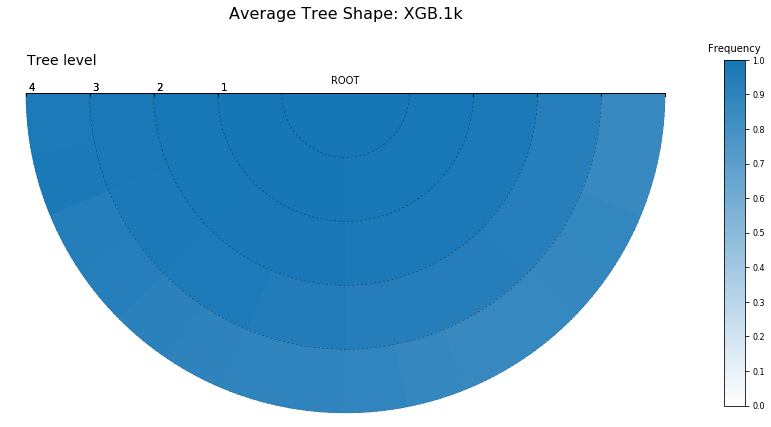

In [6]:
xgb_1K_stats = topological_analysis(xgb_1K, include_leaves=False)
fig = plot_shape(xgb_1K_stats, max_level=10)

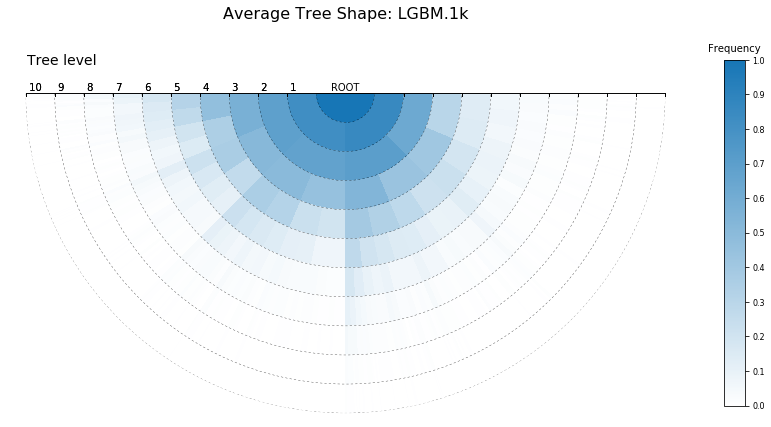

In [7]:
lgbm_1K_stats = topological_analysis(lgbm_1K, include_leaves=False)
fig = plot_shape(lgbm_1K_stats, max_level=10)

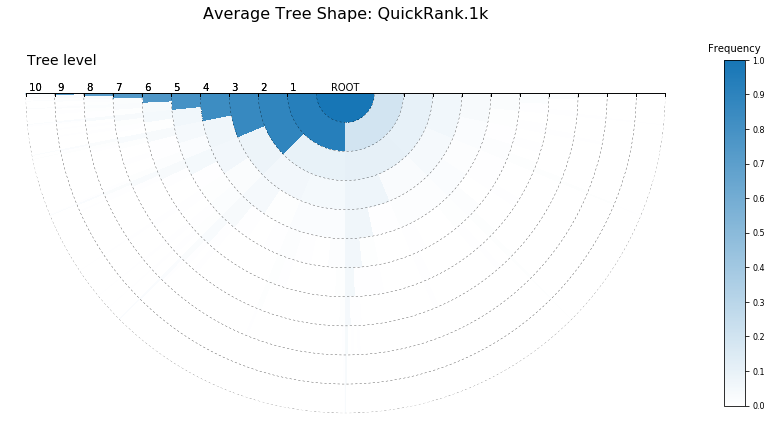

In [8]:
fig = plot_shape(qr_1K_stats, max_level=10)

We analyze the performance of the above models in the next tutorial: [RankEval - Statistical Analysis](RankEval%20-%20Statistical%20Analysis.ipynb).